<a href="https://colab.research.google.com/github/samaneh-m/TU-simulation-base-inference/blob/main/thelastmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "bayesflow>=2.0"
!pip install tensorflow hmmlearn

INFO:bayesflow:Using backend 'tensorflow'
INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - loss: 31.7730
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: -16.9918
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: -28.6711
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: -37.6722
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: -43.5135
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: -49.3170
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: -53.9338
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: -57.9385
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: -62.1101
Epoch 10/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: -65.3099
Epoch 11/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: -68.3874
Epoch 12/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: -71.6638
Epoch 13/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: -74.5746
Epoch 14/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: -77.5532
Epoch 15/50
20

       hidden_states_0  hidden_states_1  hidden_states_2  hidden_states_3  \
count         3.000000         3.000000         3.000000         3.000000   
mean          0.205247         0.259711         0.290494         0.318328   
std           0.162756         0.257427         0.316542         0.348140   
min           0.018509         0.010088         0.013333         0.042105   
25%           0.149394         0.127421         0.118023         0.122804   
50%           0.280279         0.244755         0.222712         0.203503   
75%           0.298616         0.384522         0.429074         0.456439   
max           0.316954         0.524290         0.635437         0.709376   

       hidden_states_4  hidden_states_5  hidden_states_6  hidden_states_7  \
count         3.000000         3.000000         3.000000         3.000000   
mean          0.316376         0.323755         0.328316         0.333274   
std           0.382459         0.388433         0.402649         0.410266  

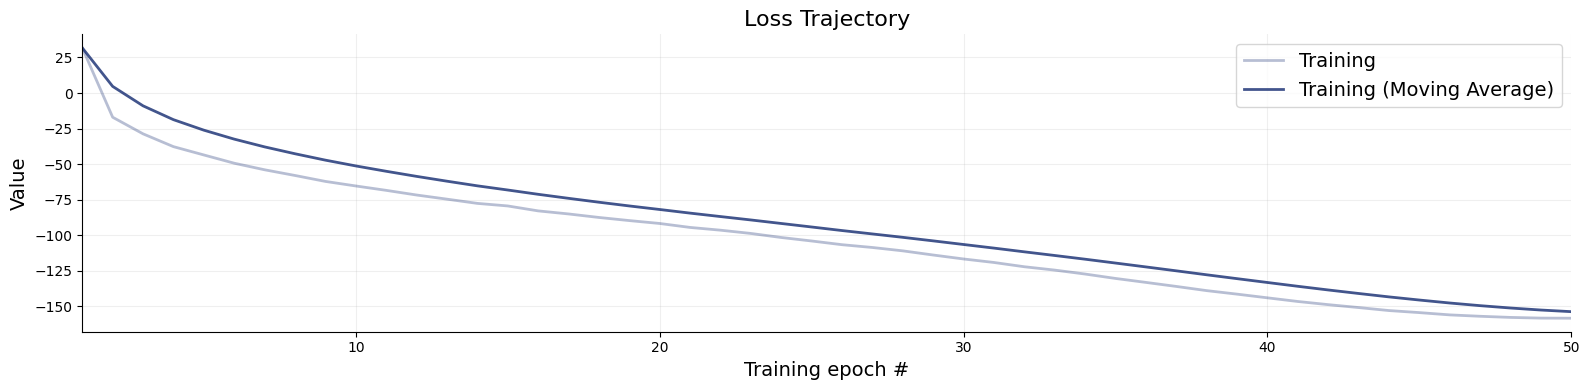

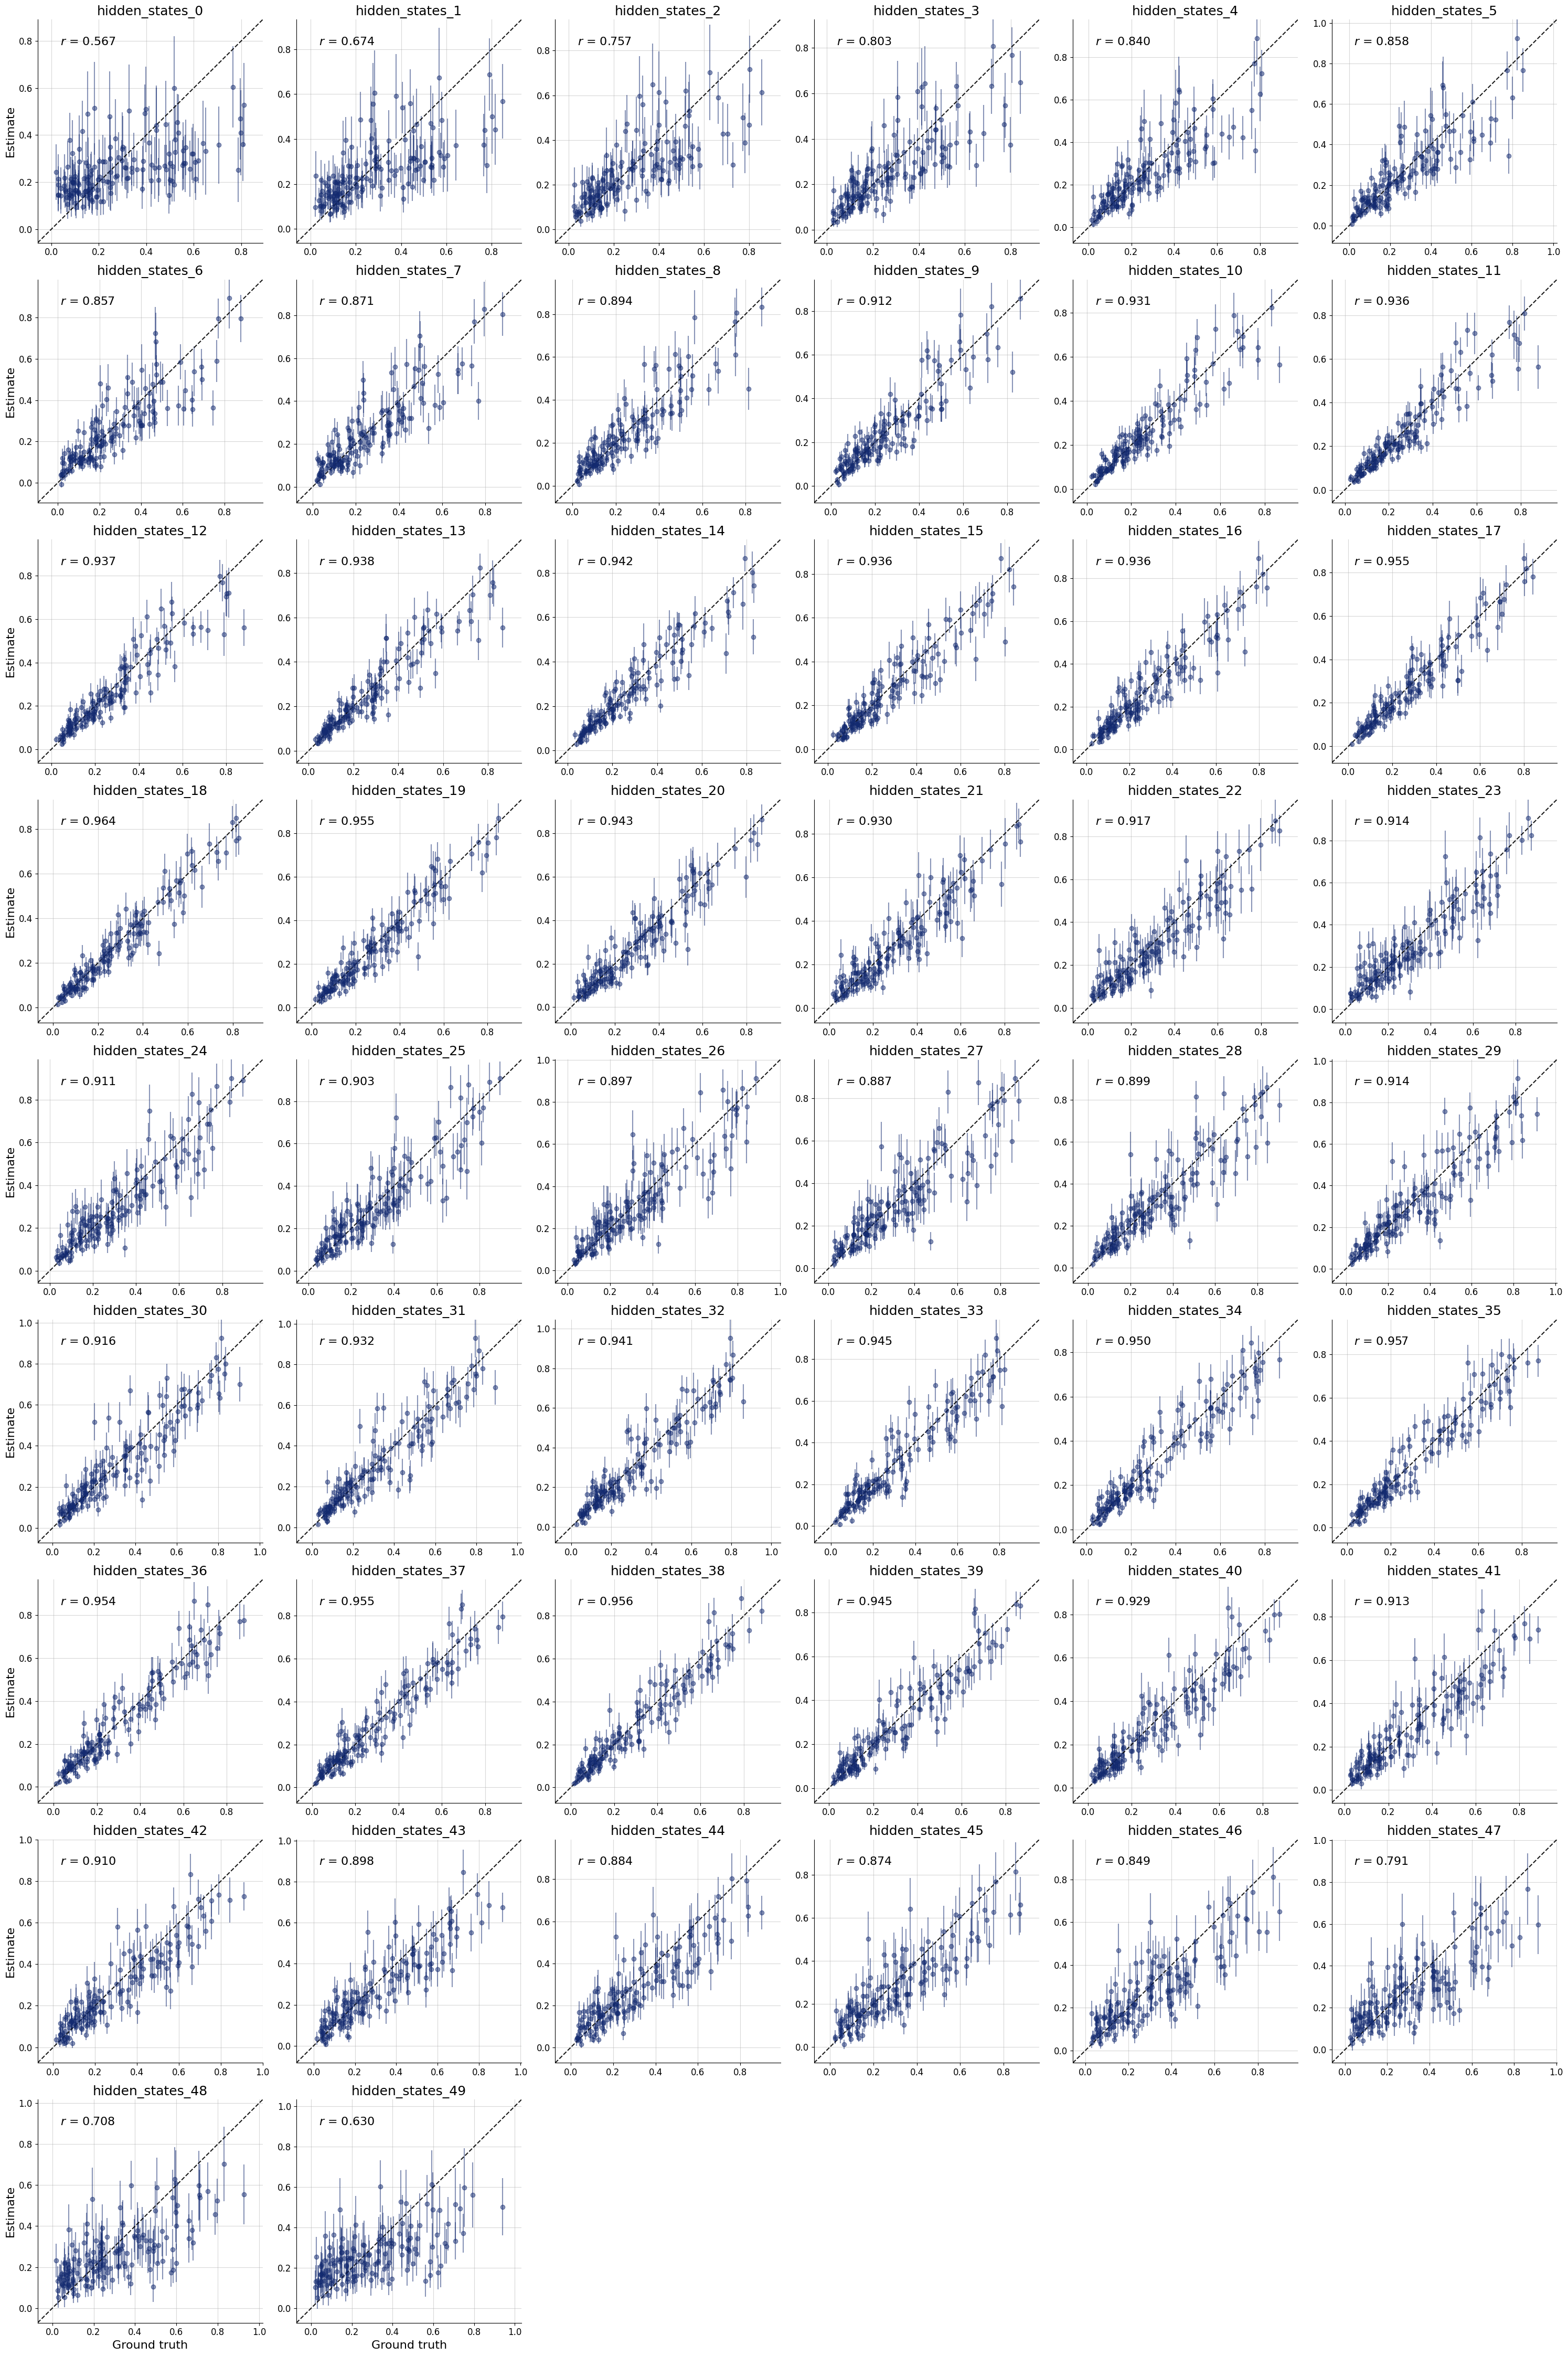

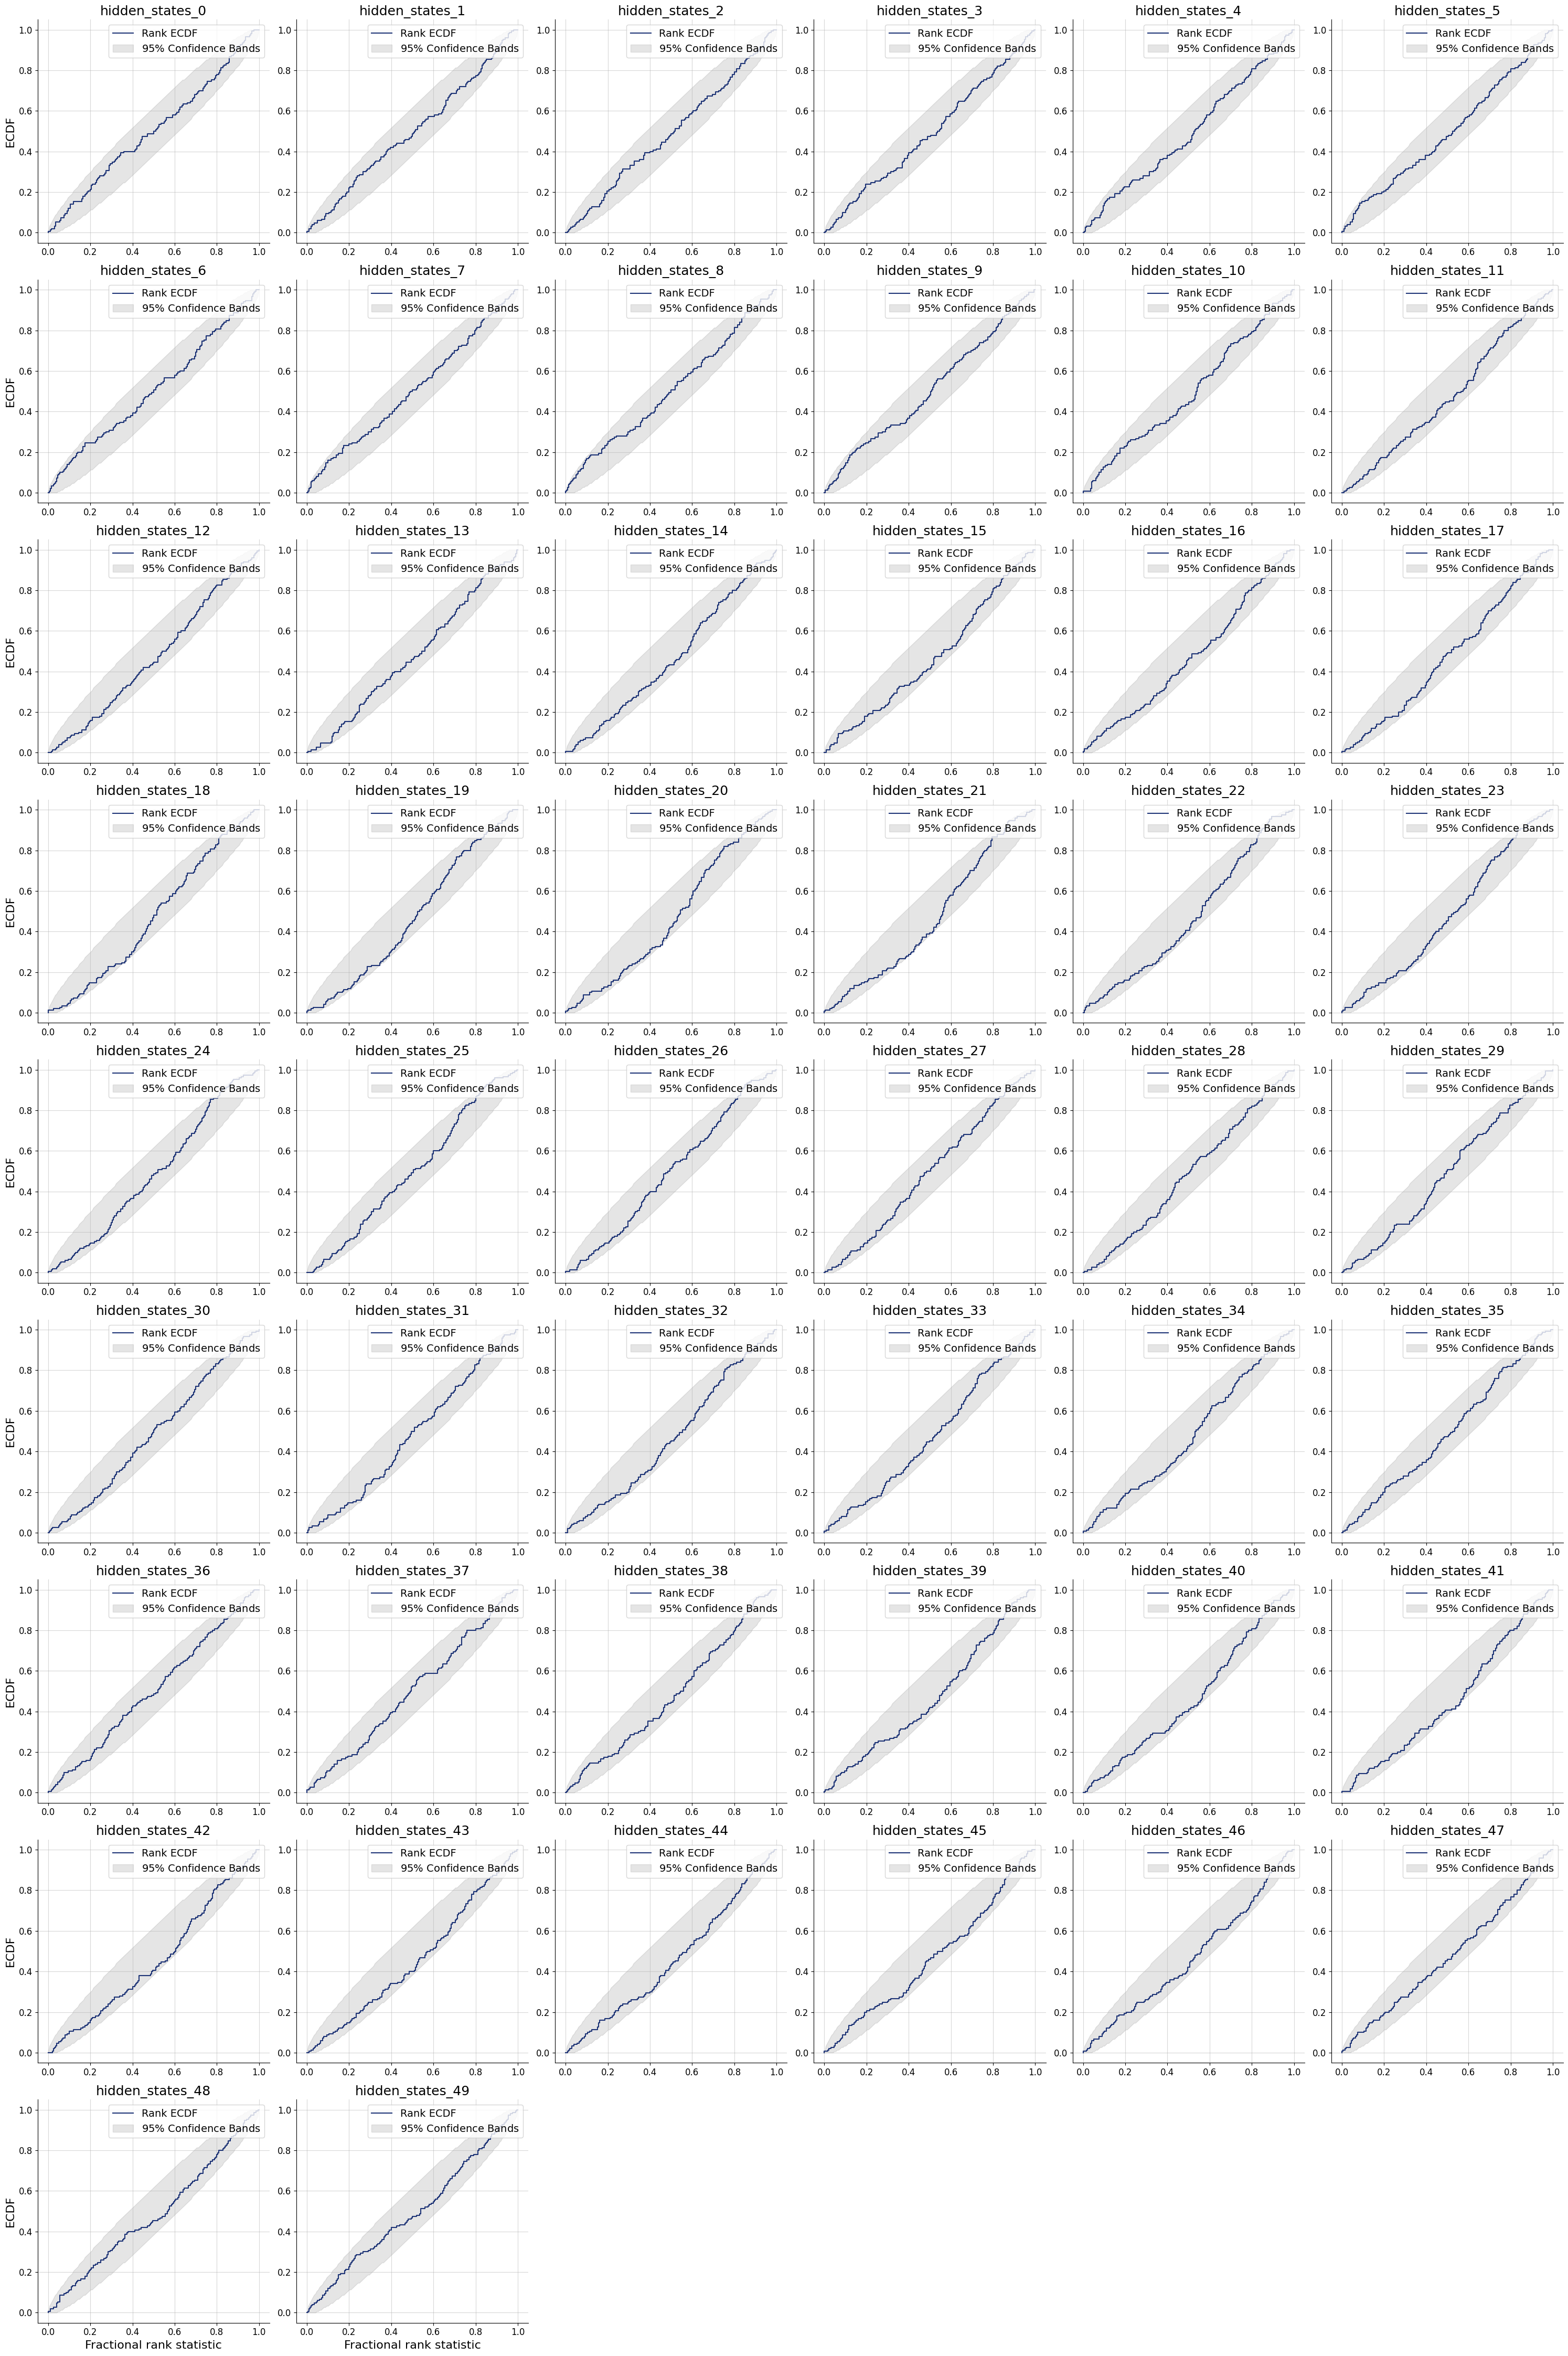

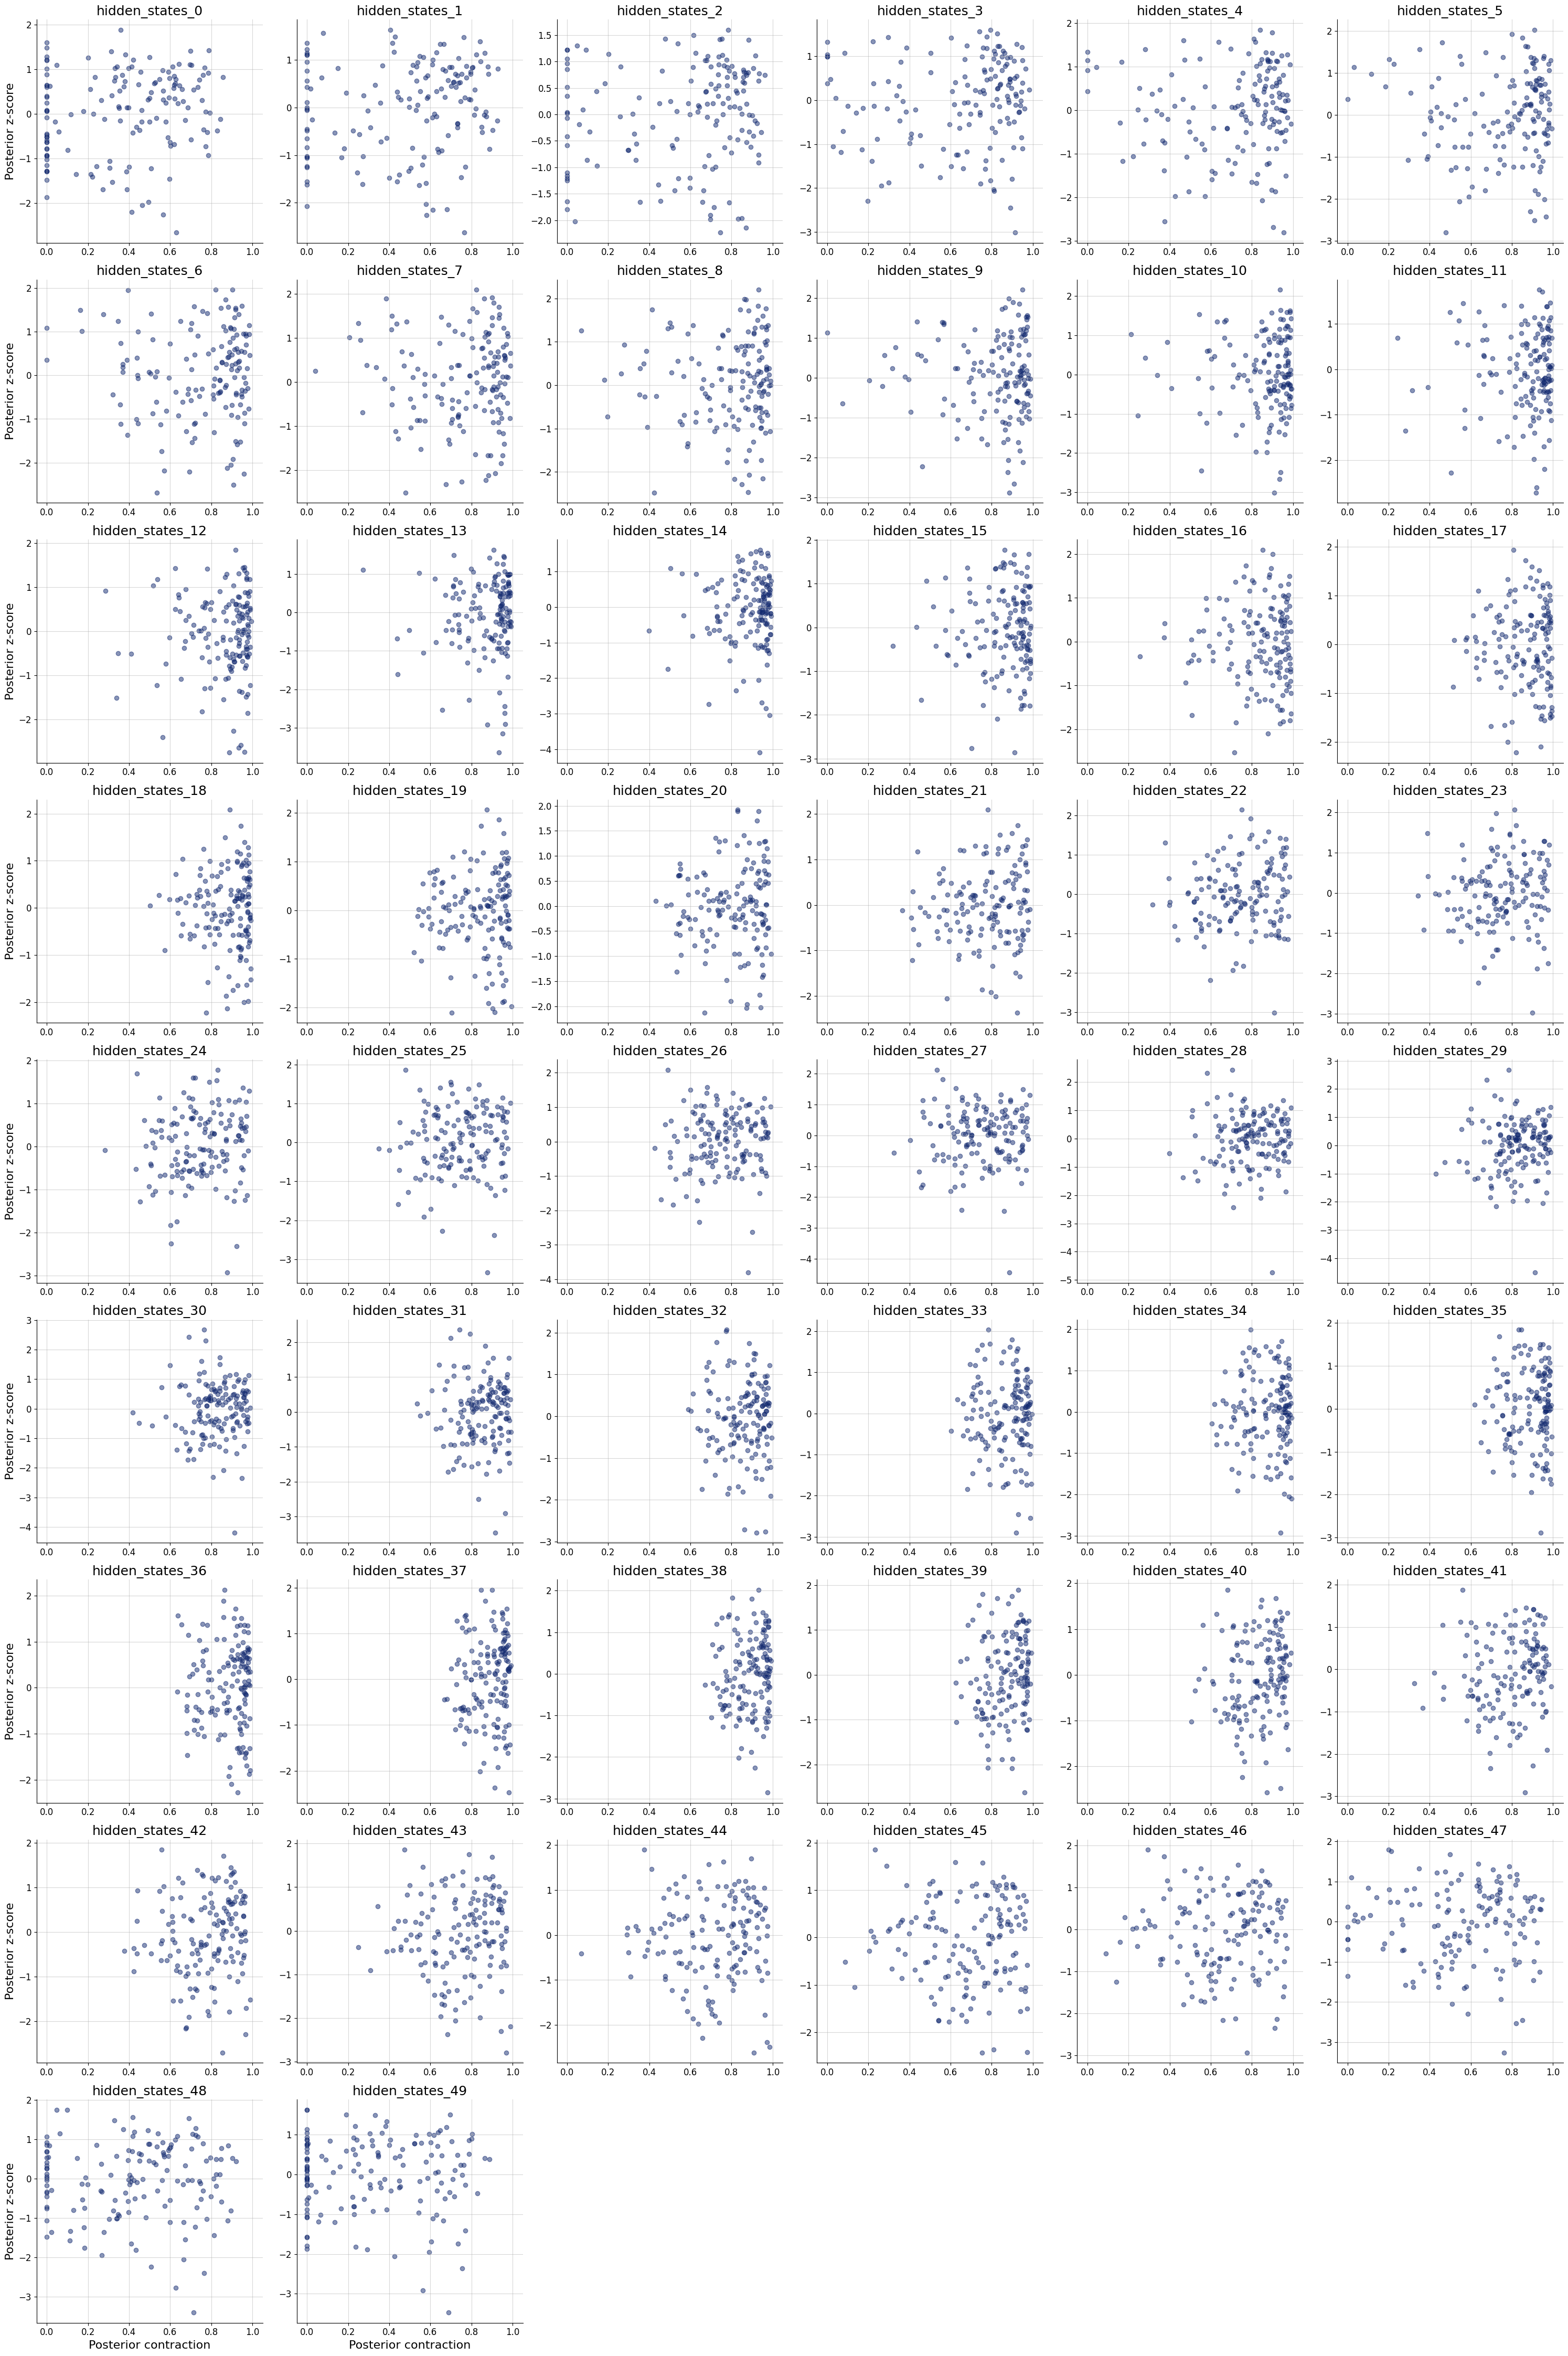

In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import bayesflow as bf
import numpy as np
import tensorflow as tf
from hmmlearn import hmm
from tensorflow.keras.utils import to_categorical
import pandas as pd
import matplotlib.pyplot as plt

# --- Define amino acid mapping ---
amino_acids = ['A','R','N','D','C','E','Q','G','H','I',
               'L','K','M','F','P','S','T','W','Y','V']
aa_to_int = {aa:i for i, aa in enumerate(amino_acids)}

# --- Custom summary network as advised by professor ---
class CustomSummaryNetwork(bf.networks.SummaryNetwork):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.network = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(200, activation="relu"),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.Dense(50, activation="relu")
        ])

    def call(self, x, **kwargs):
        return self.network(x, training=kwargs.get("stage") == "training")

    def compute_metrics(self, x, stage=None, **kwargs):
        summary = self.network(x, training=stage == "training")
        return {"outputs": summary}

# --- HMM simulator for training data ---
class HMMHiddenStateSimulator:
    def __init__(self, seq_len=50):
        self.seq_len = seq_len
        self.transmat = np.array([[0.90, 0.10],[0.05, 0.95]])
        self.startprob = np.array([0.0, 1.0])
        emissions = {
            'alpha': np.array([12,6,3,5,1,9,5,4,2,7,12,6,3,4,2,5,4,1,3,6]) / 100,
            'other': np.array([6,5,5,6,2,5,3,9,3,5,8,6,2,4,6,7,6,1,4,7]) / 100
        }
        self.emissionprob = np.stack([emissions['alpha'], emissions['other']])
        self.model = hmm.CategoricalHMM(n_components=2, n_iter=100, init_params="")
        self.model.startprob_ = self.startprob
        self.model.transmat_ = self.transmat
        self.model.emissionprob_ = self.emissionprob

    def sample(self, n_sequences=1000):
        X = []
        for _ in range(n_sequences):
            seq, _ = self.model.sample(n_samples=self.seq_len)
            X.append(seq.flatten())
        X_all = np.concatenate(X).reshape(-1, 1)
        post_probs = self.model.predict_proba(X_all)
        theta_post = post_probs[:, 0].reshape(n_sequences, self.seq_len)
        x_obs = np.array(X).reshape(n_sequences, self.seq_len)
        return x_obs, theta_post

# --- Replay simulator wrapper ---
class ReplaySimulator:
    def __init__(self, x_data, theta_data):
        self.x = x_data
        self.theta = theta_data
        self.n = theta_data.shape[0]

    def sample(self, batch_size):
        idx = np.random.choice(self.n, size=batch_size, replace=False)
        return {"hidden_states": self.theta[idx], "observations": self.x[idx]}

# --- Simulate data and encode ---
sim = HMMHiddenStateSimulator(seq_len=50)
x_train, theta_train = sim.sample(n_sequences=1000)
x_train_onehot = to_categorical(x_train, num_classes=20)

# --- BayesFlow setup ---
N, seq_len, AA = x_train_onehot.shape

summary_net = CustomSummaryNetwork()

inference_net = bf.networks.CouplingFlow(
    n_parameters=seq_len,
    context_summary=["observations"],
    coupling_layers=6,
    hidden_sizes=[128, 128]
)

simulator = ReplaySimulator(x_train_onehot, theta_train)

workflow = bf.BasicWorkflow(
    inference_network=inference_net,
    summary_network=summary_net,
    inference_variables=["hidden_states"],
    summary_variables=["observations"],
    simulator=simulator
)

# --- Train model ---
history = workflow.fit_online(
    epochs=50,
    batch_size=64,
    num_batches_per_epoch=200
)

# --- Evaluate diagnostics ---
workflow.plot_diagnostics(test_data=150, num_samples=200)
df_metrics = workflow.compute_default_diagnostics(
    test_data=150,
    num_samples=200,
    as_data_frame=True
)
print(df_metrics.describe())